Please use the following data set: https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv

- Please send an E-Mail to lukas.marx@uni-passau in order to receive your personal data timeline.
- Import and prepare the data as you are used to
- Build a small Autoencoder with an Encoder output dimension of 3
- Take a look at the top 10 and lowest 10 in terms of square root of squared errors, plot their normalized returns (each close price divided by the first close price) over the whole time period and calculate the correlation, what do you see ? 
- Build several different Autoencoder with 3,5,8,11 Encoder output dimensions, both linear and non-linear (therefore 8 in Total).
- Compare the constiuants of top 40 and lowest 40 companies in terms of square root of squared erros (for comparison calculate the percentage of matching companies). 
- Send your solution to lukas.marx@uni-passau.de

Deadline: 01.02.2023 2pm (14:00) 


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import seaborn as sns

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv', index_col = 'date')
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,0.123676,8.664290,4.9977,10.592284,14.556592,8.9131,13.007511,16.675596,493.513336,25.293035,...,9.802009,28.258766,22.608261,9.080934,12.959832,NaN,7.992623,9.964503,14.441016,3.740663
1998-01-05,0.120823,8.712471,5.0671,10.622808,14.753723,9.0913,12.912563,16.614594,490.152191,24.946089,...,9.705754,28.684456,22.389481,9.239215,13.083271,NaN,8.105922,9.878420,14.280560,3.628285
1998-01-06,0.144131,8.567928,5.2368,10.378607,14.784045,9.3587,12.722677,16.573921,488.191773,24.685869,...,9.609494,28.946413,22.644733,9.041370,13.165551,NaN,8.085321,9.738531,13.770018,3.475768
1998-01-07,0.133190,8.624138,5.1597,11.019638,14.586929,9.0457,12.608740,16.512913,483.429932,24.703232,...,9.449069,28.193266,22.498867,8.843530,13.124411,NaN,7.817531,9.641684,14.207628,3.467741
1998-01-08,0.138423,8.736559,5.2060,10.958587,14.526262,9.2540,12.456830,16.553585,480.909332,24.460360,...,9.609494,28.356985,21.878969,8.645684,12.939268,NaN,7.570335,9.663206,13.901303,3.331276


In [13]:
df.isna().any(axis=1).sum()

4396

In [14]:
df.shape

(6270, 194)

In [15]:
# a function which transforms closing prices either to returns, total cumulative returns or to log_prices
def make_transformation(df, type):
  if type == 'returns':
    new_df = df.pct_change()
    new_df = new_df.dropna()
  elif type == 'cumulative_returns':
    new_df = (df / df.iloc[0] - 1)
    new_df = new_df.iloc[1:, :]
  elif type == 'log':
    new_df = df.apply(np.log)
  elif type == 'fst_diff':
    new_df = df.diff()
    new_df = new_df.dropna()
  elif type == 'as_is':
    new_df = df.copy()
  else:
    print('Please choose among type: returns, cumulative_returns, log, fst_diff or as_is')

  return new_df

url = 'https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv'
close_df = pd.read_csv(url)
close_df = close_df.drop( close_df.columns[close_df.isnull().sum() > 0], axis = 1)
close_df.set_index(pd.to_datetime(close_df.date), inplace = True)
close_df.drop(['date'], axis = 1, inplace = True)

close_df.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WBA,WFC,WHR,WM,WMB,WMT,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,0.123676,8.664290,4.9977,10.592284,14.556592,8.9131,13.007511,16.675596,493.513336,25.293035,...,10.054314,9.802009,28.258766,22.608261,9.080934,12.959832,7.992623,9.964503,14.441016,3.740663
1998-01-05,0.120823,8.712471,5.0671,10.622808,14.753723,9.0913,12.912563,16.614594,490.152191,24.946089,...,10.074628,9.705754,28.684456,22.389481,9.239215,13.083271,8.105922,9.878420,14.280560,3.628285
1998-01-06,0.144131,8.567928,5.2368,10.378607,14.784045,9.3587,12.722677,16.573921,488.191773,24.685869,...,10.013694,9.609494,28.946413,22.644733,9.041370,13.165551,8.085321,9.738531,13.770018,3.475768
1998-01-07,0.133190,8.624138,5.1597,11.019638,14.586929,9.0457,12.608740,16.512913,483.429932,24.703232,...,9.993381,9.449069,28.193266,22.498867,8.843530,13.124411,7.817531,9.641684,14.207628,3.467741
1998-01-08,0.138423,8.736559,5.2060,10.958587,14.526262,9.2540,12.456830,16.553585,480.909332,24.460360,...,9.769954,9.609494,28.356985,21.878969,8.645684,12.939268,7.570335,9.663206,13.901303,3.331276


In [16]:
close_df.tail()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WBA,WFC,WHR,WM,WMB,WMT,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
2022-11-23,151.07,106.02,335.78,96.78,262.58,197.07,88.139999,95.13,60.96,133.489563,...,41.76,47.33,148.35,163.374374,33.83,152.42,31.973084,69.20,113.61,125.93
2022-11-25,148.11,106.96,334.30,97.40,263.95,200.66,88.809998,95.47,61.08,134.552704,...,41.66,47.44,148.77,163.822647,33.90,153.07,32.132202,69.63,113.21,126.53
2022-11-28,144.22,105.39,328.97,96.25,258.33,195.35,87.940002,95.22,60.74,131.869995,...,40.81,46.98,143.82,163.952133,33.48,153.51,31.038254,69.39,109.81,126.45
2022-11-29,141.17,105.00,326.78,96.45,257.06,195.18,87.239998,94.65,61.44,133.380005,...,41.08,47.57,145.98,164.440231,34.32,152.97,31.585228,68.85,110.54,126.04
2022-11-30,148.03,107.58,344.93,97.50,264.14,201.95,89.320000,96.80,63.11,133.900000,...,41.50,47.95,146.53,167.070007,34.70,152.42,32.529999,70.22,111.34,128.66


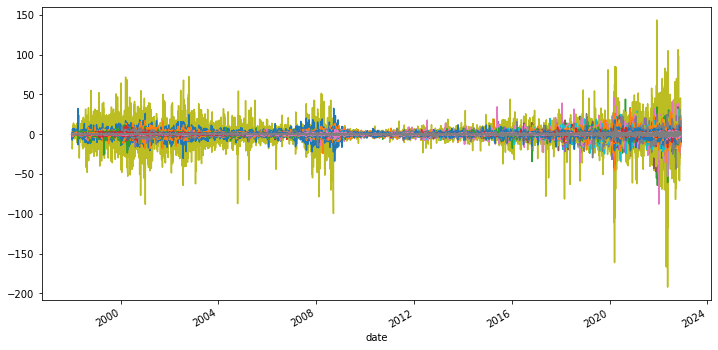

In [17]:
transformation_type = 'fst_diff'
fin_df = make_transformation(close_df, transformation_type)
fin_df.plot(legend = False, figsize = (12, 6))

In [18]:
df_discrete = close_df.pct_change().dropna()
df_discrete.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WBA,WFC,WHR,WM,WMB,WMT,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
1998-01-05,-0.023076,0.005561,0.013886,0.002882,0.013542,0.019993,-0.007299,-0.003658,-0.006811,-0.013717,...,0.002020,-0.009820,0.015064,-0.009677,0.017430,0.009525,0.014175,-0.008639,-0.011111,-0.030042
1998-01-06,0.192914,-0.016590,0.033491,-0.022988,0.002055,0.029413,-0.014706,-0.002448,-0.004000,-0.010431,...,-0.006048,-0.009918,0.009132,0.011401,-0.021414,0.006289,-0.002541,-0.014161,-0.035751,-0.042036
1998-01-07,-0.075908,0.006560,-0.014723,0.061765,-0.013333,-0.033445,-0.008955,-0.003681,-0.009754,0.000703,...,-0.002029,-0.016694,-0.026019,-0.006442,-0.021882,-0.003125,-0.033121,-0.009945,0.031780,-0.002309
1998-01-08,0.039284,0.013036,0.008973,-0.005540,-0.004159,0.023028,-0.012048,0.002463,-0.005214,-0.009832,...,-0.022357,0.016978,0.005807,-0.027552,-0.022372,-0.014107,-0.031621,0.002232,-0.021561,-0.039353
1998-01-09,0.000000,-0.011029,-0.022224,-0.025070,-0.019833,-0.075567,0.009147,-0.006142,-0.038439,-0.041135,...,0.002078,-0.046744,-0.035797,-0.016667,-0.013730,-0.028617,-0.017687,-0.010023,-0.024134,0.002410


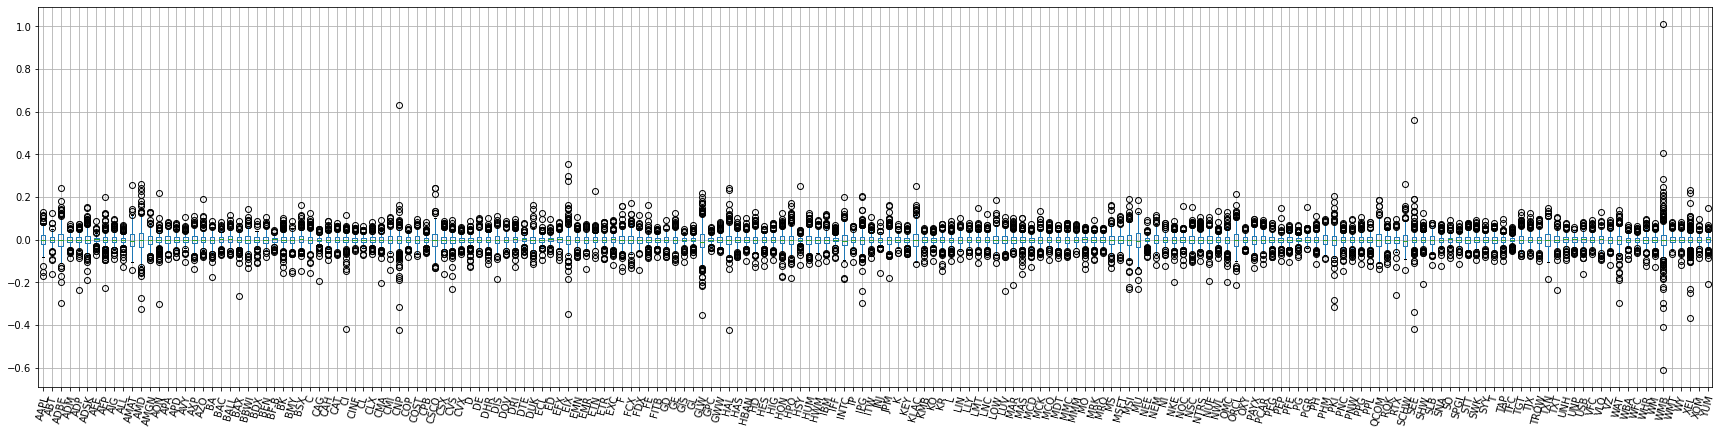

In [19]:
n_days_per_year = 252
n_years_to_use = 2
n_estimation_days = n_days_per_year * n_years_to_use

idx = pd.to_datetime('2003-01-02')
t = df_discrete.index.get_loc(idx)

df_train = df_discrete.iloc[(t-n_estimation_days):t, :]
df_test = df_discrete.iloc[t:(t+n_days_per_year), :]

# visual check for outliers
df_train.boxplot(figsize = (30, 7), rot = 75)

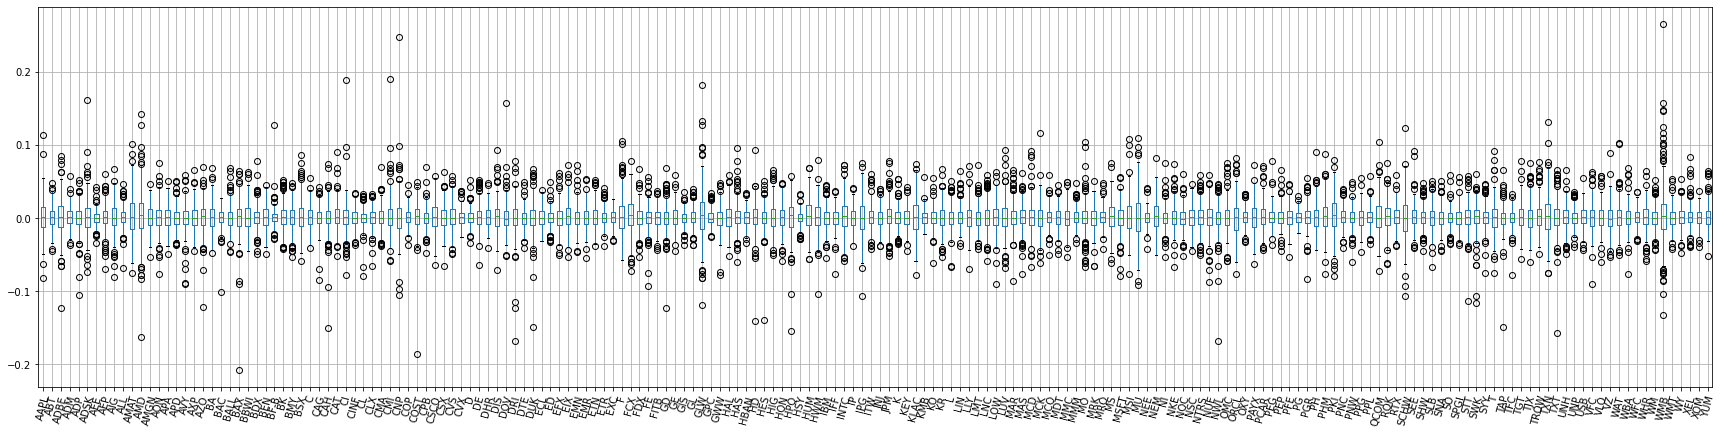

In [20]:
df_test.boxplot(figsize = (30, 7), rot = 75)

In [21]:
# training and test data
X_train, X_test = df_train.values, df_test.values

# dimension of latent representation
n_hidden = 3

# define a linear autoencoder
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(df_train.shape[1])
])

#encoder = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
#    tf.keras.layers.Dense(20, activation = 'relu'),
#    tf.keras.layers.Dense(n_hidden)
#])

#decoder = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
#    tf.keras.layers.Dense(20, activation = 'relu'),
#    tf.keras.layers.Dense(df_train.shape[1])
#])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 1s 13ms/step - loss: 7.8993e-04 - val_loss: 3.3743e-04
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 7.6083e-04 - val_loss: 3.2962e-04
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 7.4119e-04 - val_loss: 3.2089e-04
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 7.1024e-04 - val_loss: 2.9988e-04
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 6.6766e-04 - val_loss: 2.7532e-04
Epoch 6/200
16/16 [==============================] - 0s 5ms/step - loss: 6.1858e-04 - val_loss: 2.5429e-04
Epoch 7/200
16/16 [==============================] - 0s 5ms/step - loss: 5.8035e-04 - val_loss: 2.3787e-04
Epoch 8/200
16/16 [==============================] - 0s 4ms/step - loss: 5.5335e-04 - val_loss: 2.2855e-04
Epoch 9/200
16/16 [==============================] - 0s 4ms/step - loss: 5.3797e-04 - val_loss: 2.2383e-04
Epoch 10/200
16/16 [================

In [22]:
# recreation of data
X_train_hat = autoencoder.predict(X_train)
X_test_hat = autoencoder.predict(X_test)

# differences of original data and recreations
Error_train = (X_train - X_train_hat)
Error_test = (X_test - X_test_hat)

error_train = pd.DataFrame(Error_train, columns = df_train.columns, index = df_train.index)
error_test = pd.DataFrame(Error_test, columns = df_test.columns, index = df_test.index)


# square root of squared errors
error_train_rsq = error_train.apply(lambda x: np.sqrt(x**2))
error_test_rsq = error_test.apply(lambda x: np.sqrt(x**2))

# avereage error per day
error_per_day_train = error_train_rsq.mean(axis = 1)
error_per_day_test = error_test_rsq.mean(axis = 1)
# average error per company
error_per_company_train = error_train_rsq.mean(axis = 0)
error_per_company_test = error_test_rsq.mean(axis = 0)

total_variation_train = df_train.apply(lambda x: x**2).sum().sum()
error_variation_train = error_train.apply(lambda x: x**2).sum().sum()
explained_variation_train = 1 - error_variation_train / total_variation_train

total_variation_test = df_test.apply(lambda x: x**2).sum().sum()
error_variation_test = error_test.apply(lambda x: x**2).sum().sum()
explained_variation_test = 1 - error_variation_test / total_variation_test

factors_train, factors_test = encoder.predict(X_train), encoder.predict(X_test)
factors_train_df, factors_test_df = pd.DataFrame(factors_train, index = df_train.index), pd.DataFrame(factors_test, index = df_test.index)

print(f'Explained variation of the autoencoder for training data: {explained_variation_train:.2f}')
print(f'Explained variation of the autoencoder for test data: {explained_variation_test:.2f}')

8/8 [==============================] - 0s 2ms/step
Explained variation of the autoencoder for training data: 0.42
Explained variation of the autoencoder for test data: 0.40


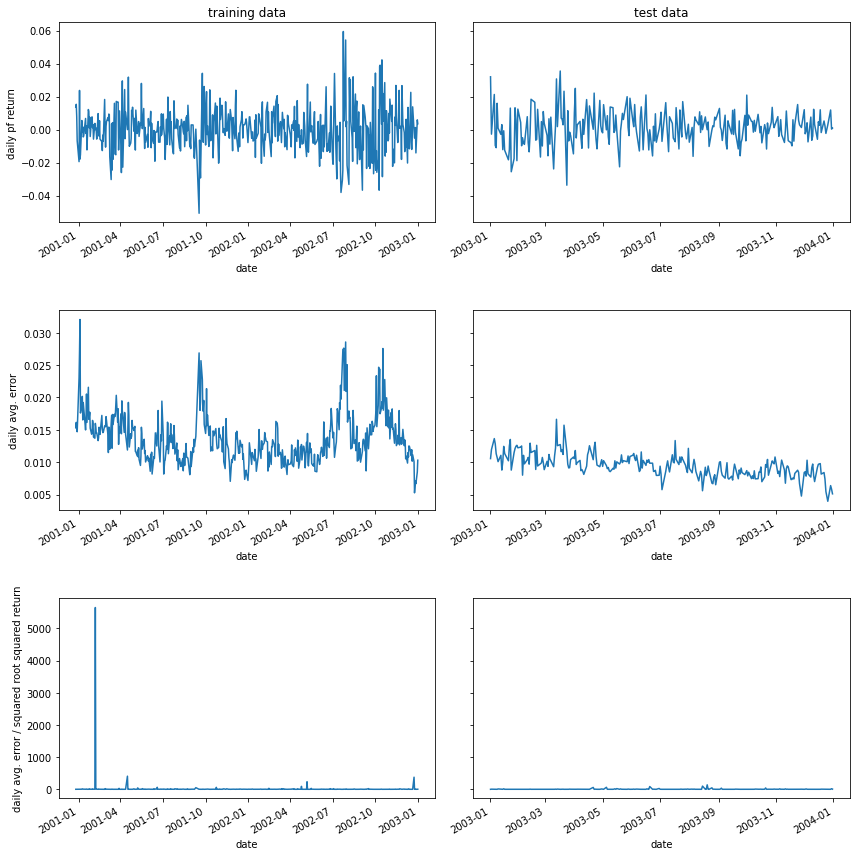

In [23]:
fig, axs = plt.subplots(3, 2, figsize = (12, 12), sharey = 'row')
df_train.mean(axis = 1).plot(ax = axs[0, 0])
df_test.mean(axis = 1).plot(ax = axs[0, 1])
error_per_day_train.plot(ax = axs[1, 0])
error_per_day_test.plot(ax = axs[1, 1])
(error_per_day_train / df_train.mean(axis = 1).apply(lambda x: np.sqrt(x**2))).plot(ax = axs[2, 0])
(error_per_day_test / df_test.mean(axis = 1).apply(lambda x: np.sqrt(x**2))).plot(ax = axs[2, 1])
axs[0, 0].set_title('training data')
axs[0, 1].set_title('test data')
axs[0, 0].set_ylabel('daily pf return')
axs[1, 0].set_ylabel('daily avg. error')
axs[2, 0].set_ylabel('daily avg. error / squared root squared return')
fig.tight_layout()

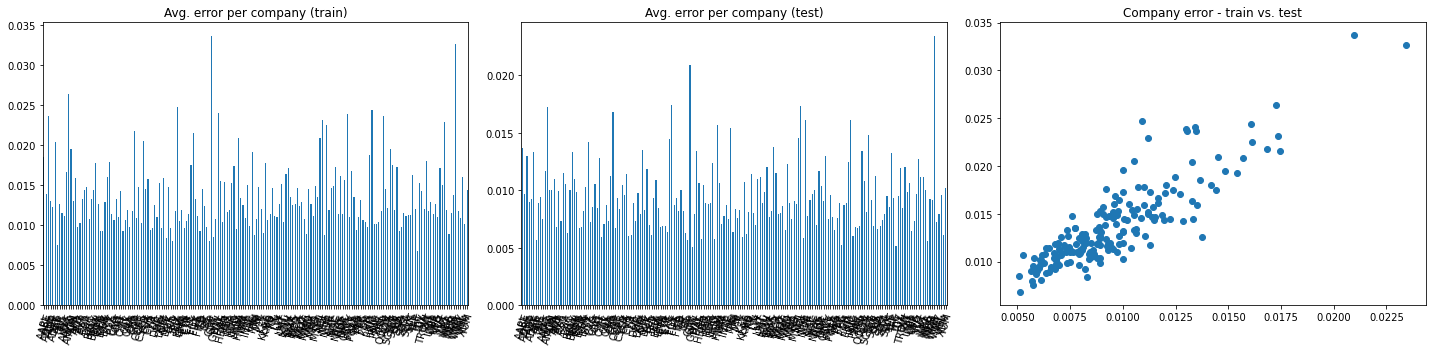

In [24]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
error_per_company_train.plot(kind = 'bar', rot = 75, ax = axs[0])
error_per_company_test.plot(kind = 'bar', rot = 75, ax = axs[1])
#axs[0].bar(df_train.columns, error_per_company_train)
#axs[1].bar(df_test.columns, error_per_company_test)
axs[2].scatter(error_per_company_test, error_per_company_train)
axs[0].set_title('Avg. error per company (train)')
axs[1].set_title('Avg. error per company (test)')
axs[2].set_title('Company error - train vs. test')
fig.tight_layout()

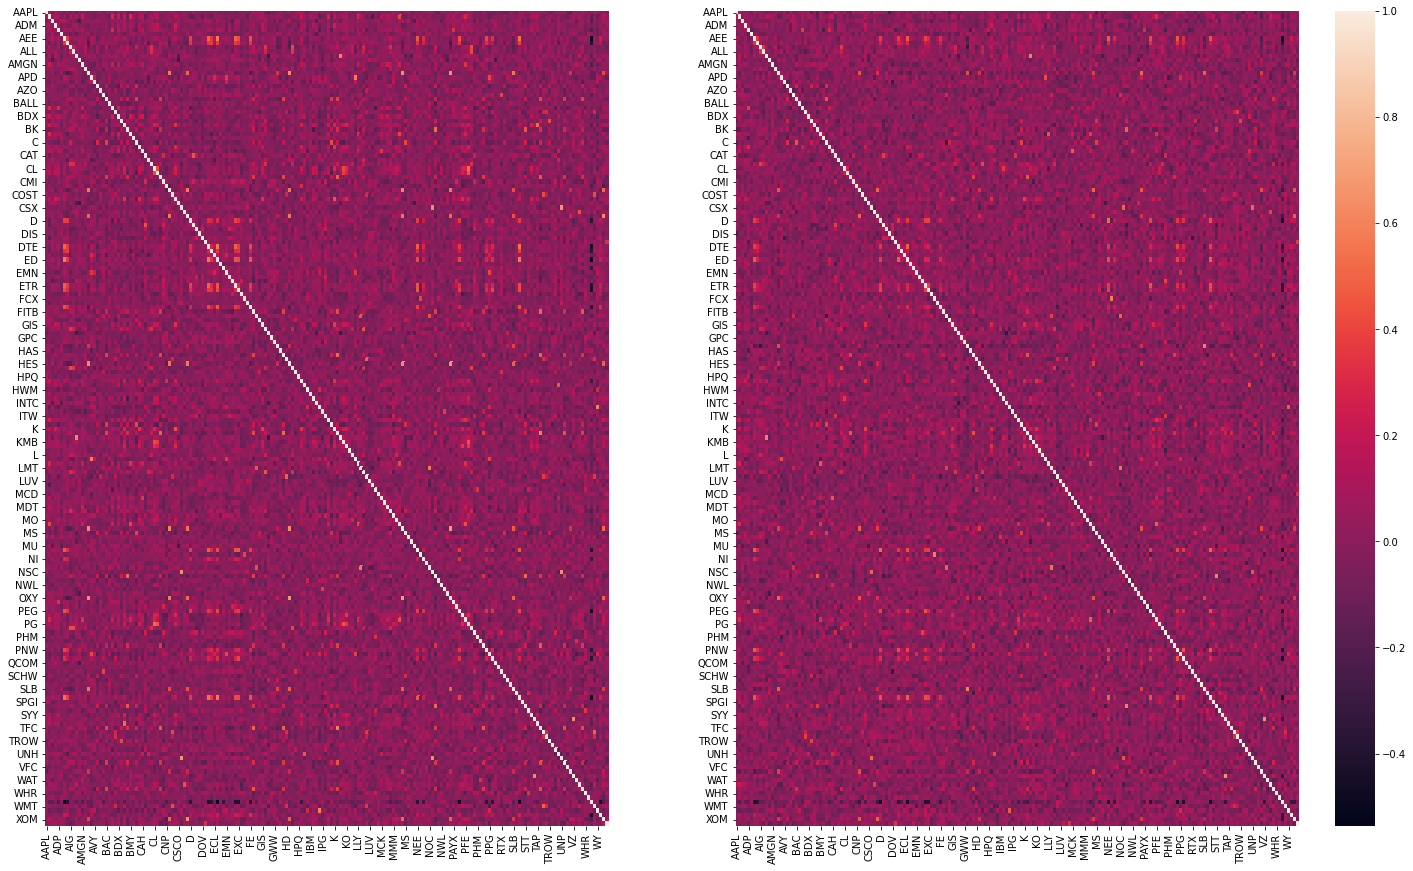

In [25]:
import seaborn as sns
import matplotlib.pylab as plt

# a heatmap with estimated correlation 
error_corr_train_df = pd.DataFrame(error_train).corr()
error_corr_test_df = pd.DataFrame(error_test).corr()

vmin = min(error_corr_train_df.values.min(), error_corr_test_df.values.min())
vmax = max(error_corr_train_df.values.max(), error_corr_test_df.values.max())

fig, axs = plt.subplots(1, 2, figsize = (25, 15), gridspec_kw=dict(width_ratios=[2,2.5]))
sns.heatmap(data = pd.DataFrame(error_train).corr(), ax = axs[0], vmin = vmin, vmax = vmax, cbar = False)
sns.heatmap(data = pd.DataFrame(error_test).corr(), ax = axs[1], vmin = vmin, vmax = vmax, cbar = True)

In [27]:
avg_corr_train = df_train.corr().abs().values[np.tril_indices(error_corr_train_df.shape[0], k = -1)].mean()
avg_corr_test = df_test.corr().abs().values[np.tril_indices(error_corr_test_df.shape[0], k = -1)].mean()
avg_res_corr_train = error_corr_train_df.abs().values[np.tril_indices(error_corr_train_df.shape[0], k = -1)].mean()
avg_res_corr_test = error_corr_test_df.abs().values[np.tril_indices(error_corr_test_df.shape[0], k = -1)].mean()
print(f'Average correlation training data: {avg_corr_train:.2f}')
print(f'Average correlation test data: {avg_corr_test:.2f}')
print(f'Average correlation left unexplained training data: {avg_res_corr_train:.2f}')
print(f'Average correlation left unexplained test data: {avg_res_corr_test:.2f}')

Average correlation training data: 0.28
Average correlation test data: 0.35
Average correlation left unexplained training data: 0.06
Average correlation left unexplained test data: 0.07


In [26]:
error_per_company_train

AAPL    0.018568
ABT     0.013933
ADBE    0.023690
ADM     0.013100
ADP     0.012334
          ...   
WMT     0.011750
WY      0.010878
XEL     0.016064
XOM     0.010133
YUM     0.014373
Length: 188, dtype: float64

In [28]:
largest_error_train = error_per_company_train.nlargest(n=10)
largest_error_test = error_per_company_test[['GLW','WMB', "AMD", "EIX", "PKI", "HAL", "ORCL", "MU", "QCOM", "ADBE"]]

largest_error_train

GLW     0.033685
WMB     0.032657
AMD     0.026391
EIX     0.024730
PKI     0.024395
HAL     0.024089
ORCL    0.023887
ADBE    0.023690
QCOM    0.023612
MU      0.023191
dtype: float64

In [30]:
smallest_error_train = error_per_company_train.nsmallest(n=10)
smallest_error_test = error_per_company_test[["TFC", "GL", "AEE", "GPC", "ED", "MMM", "WFC", "ITW", "KEY", "BF-B"]]

smallest_error_train

TFC    0.006770
AEE    0.007549
GL     0.007973
ED     0.008058
DTE    0.008388
GPC    0.008533
NEE    0.008728
ITW    0.008848
MMM    0.008862
WFC    0.008971
dtype: float64

In [31]:
n_return_GLW = close_df["GLW"]/close_df["GLW"][0]
n_return_WMB = close_df["WMB"]/close_df["WMB"][0]
n_return_AMD = close_df["AMD"]/close_df["AMD"][0]
n_return_EIX = close_df["EIX"]/close_df["EIX"][0]
n_return_PKI = close_df["PKI"]/close_df["PKI"][0]
n_return_HAL = close_df["HAL"]/close_df["HAL"][0]
n_return_ORCL = close_df["ORCL"]/close_df["ORCL"][0]
n_return_MU = close_df["MU"]/close_df["MU"][0]
n_return_QCOM = close_df["QCOM"]/close_df["QCOM"][0]
n_return_ADBE = close_df["ADBE"]/close_df["ADBE"][0]

n_return_TFC = close_df["TFC"]/close_df["TFC"][0]
n_return_GL = close_df["GL"]/close_df["GL"][0]
n_return_AEE = close_df["AEE"]/close_df["AEE"][0]
n_return_GPC = close_df["GPC"]/close_df["GPC"][0]
n_return_ED = close_df["ED"]/close_df["ED"][0]
n_return_MMM = close_df["MMM"]/close_df["MMM"][0]
n_return_WFC = close_df["WFC"]/close_df["WFC"][0]
n_return_ITW = close_df["ITW"]/close_df["ITW"][0]
n_return_KEY = close_df["KEY"]/close_df["KEY"][0]
n_return_BFB = close_df["BF-B"]/close_df["BF-B"][0]


<function matplotlib.pyplot.show(*args, **kw)>

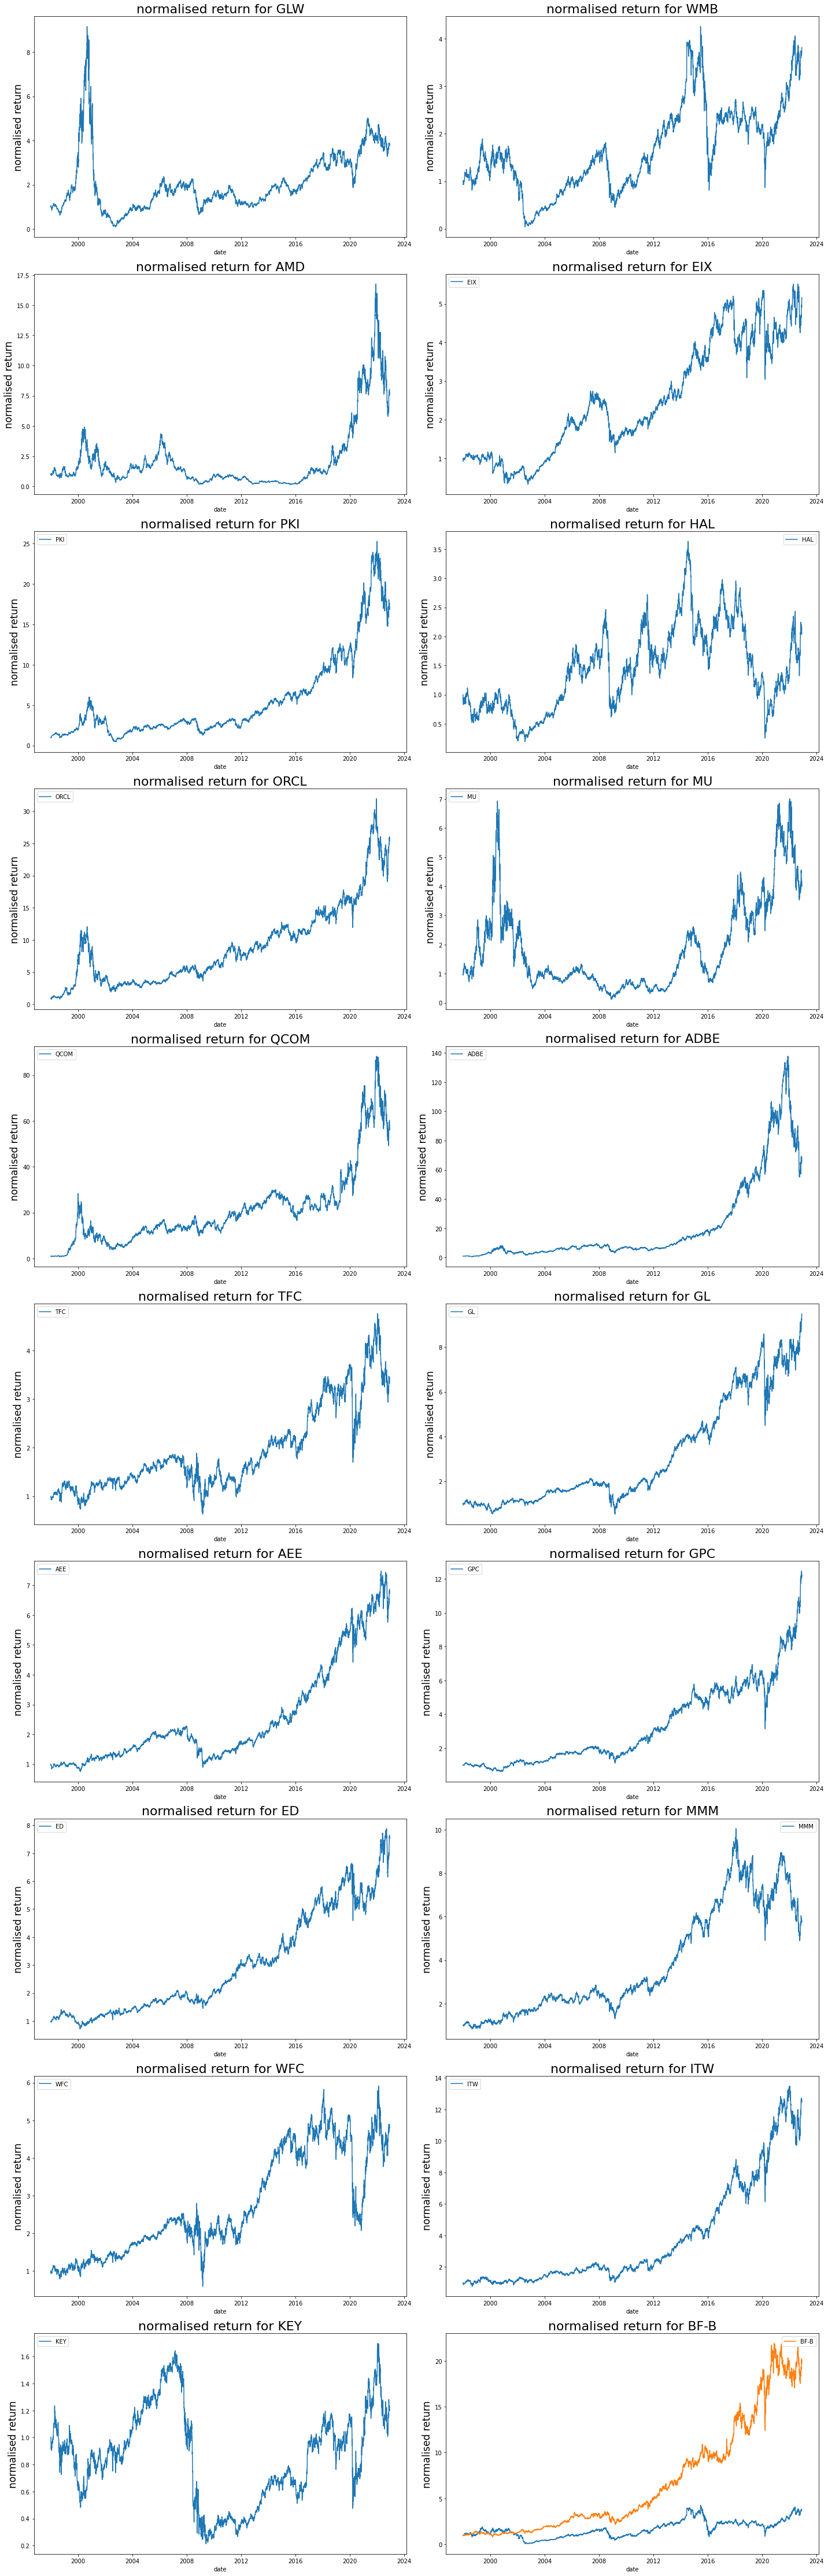

In [32]:
fig, axes = plt.subplots(10,2, figsize = (20, 62))

ax = axes[0][0]
ax.plot(n_return_GLW,)
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for GLW", fontsize=22)


ax = axes[0][1]
ax.plot(n_return_WMB, label="WMB")
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for WMB", fontsize=22)
plt.plot(n_return_WMB)

ax = axes[1][0]
ax.plot(n_return_AMD, label="AMD")
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for AMD", fontsize=22)

ax = axes[1][1]
ax.plot(n_return_EIX, label="EIX")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for EIX", fontsize=22)

ax = axes[2][0]
ax.plot(n_return_PKI, label="PKI")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for PKI", fontsize=22)

ax = axes[2][1]
ax.plot(n_return_HAL, label="HAL")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for HAL", fontsize=22)

ax = axes[3][0]
ax.plot(n_return_ORCL, label="ORCL")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for ORCL", fontsize=22)

ax = axes[3][1]
ax.plot(n_return_MU, label="MU")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for MU", fontsize=22)

ax = axes[4][0]
ax.plot(n_return_QCOM, label="QCOM")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for QCOM", fontsize=22)

ax = axes[4][1]
ax.plot(n_return_ADBE, label="ADBE")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for ADBE", fontsize=22)

ax = axes[5][0]
ax.plot(n_return_TFC, label="TFC")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for TFC", fontsize=22)

ax = axes[5][1]
ax.plot(n_return_GL, label="GL")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for GL", fontsize=22)

ax = axes[6][0]
ax.plot(n_return_AEE, label="AEE")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for AEE", fontsize=22)

ax = axes[6][1]
ax.plot(n_return_GPC, label="GPC")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for GPC", fontsize=22)

ax = axes[7][0]
ax.plot(n_return_ED, label="ED")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for ED", fontsize=22)

ax = axes[7][1]
ax.plot(n_return_MMM, label="MMM")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for MMM", fontsize=22)

ax = axes[8][0]
ax.plot(n_return_WFC, label="WFC")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for WFC", fontsize=22)

ax = axes[8][1]
ax.plot(n_return_ITW, label="ITW")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for ITW", fontsize=22)

ax = axes[9][0]
ax.plot(n_return_KEY, label="KEY")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for KEY", fontsize=22)

ax = axes[9][1]
ax.plot(n_return_BFB, label="BF-B")
ax.legend()
ax.set_xlabel("date")
ax.set_ylabel("normalised return", fontsize=17)
ax.set_title("normalised return for BF-B", fontsize=22)

plt.tight_layout()
plt.show

In [33]:
error_train_minmax = error_train[['GLW','WMB', "AMD", "EIX", "PKI", "HAL", "ORCL", "MU", "QCOM", "ADBE","TFC", "GL", "AEE", "GPC", "ED", "MMM", "WFC", "ITW", "KEY", "BF-B"]]
error_test_minmax = error_test[['GLW','WMB', "AMD", "EIX", "PKI", "HAL", "ORCL", "MU", "QCOM", "ADBE","TFC", "GL", "AEE", "GPC", "ED", "MMM", "WFC", "ITW", "KEY", "BF-B"]]

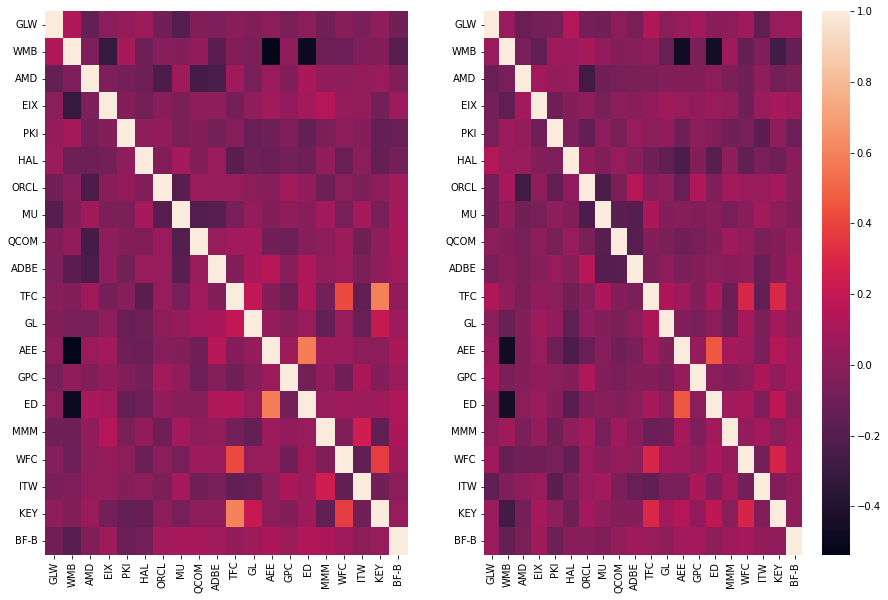

In [34]:
import seaborn as sns
import matplotlib.pylab as plt

# a heatmap with estimated correlation 
error_corr_train_df = pd.DataFrame(error_train_minmax).corr()
error_corr_test_df = pd.DataFrame(error_test_minmax).corr()

vmin = min(error_corr_train_df.values.min(), error_corr_test_df.values.min())
vmax = max(error_corr_train_df.values.max(), error_corr_test_df.values.max())

fig, axs = plt.subplots(1, 2, figsize = (15, 10), gridspec_kw=dict(width_ratios=[5,5.5]))
sns.heatmap(data = pd.DataFrame(error_train_minmax).corr(), ax = axs[0], vmin = vmin, vmax = vmax, cbar = False)
sns.heatmap(data = pd.DataFrame(error_test_minmax).corr(), ax = axs[1], vmin = vmin, vmax = vmax, cbar = True)

In [35]:
avg_corr_train = df_train.corr().abs().values[np.tril_indices(error_corr_train_df.shape[0], k = -1)].mean()
avg_corr_test = df_test.corr().abs().values[np.tril_indices(error_corr_test_df.shape[0], k = -1)].mean()
avg_res_corr_train = error_corr_train_df.abs().values[np.tril_indices(error_corr_train_df.shape[0], k = -1)].mean()
avg_res_corr_test = error_corr_test_df.abs().values[np.tril_indices(error_corr_test_df.shape[0], k = -1)].mean()
print(f'Average correlation training data: {avg_corr_train:.2f}')
print(f'Average correlation test data: {avg_corr_test:.2f}')
print(f'Average correlation left unexplained training data: {avg_res_corr_train:.2f}')
print(f'Average correlation left unexplained test data: {avg_res_corr_test:.2f}')

Average correlation training data: 0.27
Average correlation test data: 0.32
Average correlation left unexplained training data: 0.09
Average correlation left unexplained test data: 0.08


## Comments:

The average correlation of the examined objects for train and test data after applying the autoencoder to make predictions is only 6% for the train set and 7% for the test set but increases to 9% for the train set and 8% for the test set when only the top and lowest 10 companies are taken into consideration!

This shows that extreme values in the error values lead to an increase in the average correlation of the variables after the autoencoder is applied, which in turn decreases the performance of our latent representation (in our case the 3 hidden neurons).

# Linear Autoencoder

In [36]:
n_hidden = 3

encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(df_train.shape[1])
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 1s 12ms/step - loss: 7.6162e-04 - val_loss: 3.2856e-04
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 7.4322e-04 - val_loss: 3.2050e-04
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 7.1789e-04 - val_loss: 3.0518e-04
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 6.8547e-04 - val_loss: 2.8483e-04
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 6.4473e-04 - val_loss: 2.6246e-04
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 6.0453e-04 - val_loss: 2.4450e-04
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 5.7093e-04 - val_loss: 2.3097e-04
Epoch 8/200
16/16 [==============================] - 0s 4ms/step - loss: 5.4814e-04 - val_loss: 2.2312e-04
Epoch 9/200
16/16 [==============================] - 0s 4ms/step - loss: 5.3393e-04 - val_loss: 2.1981e-04
Epoch 10/200
16/16 [================

In [37]:
n_hidden = 5

# define a linear autoencoder
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(df_train.shape[1])
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 1s 11ms/step - loss: 7.8863e-04 - val_loss: 3.3758e-04
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 7.5919e-04 - val_loss: 3.2464e-04
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 7.2679e-04 - val_loss: 3.0560e-04
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 6.8410e-04 - val_loss: 2.8093e-04
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 6.3430e-04 - val_loss: 2.5592e-04
Epoch 6/200
16/16 [==============================] - 0s 9ms/step - loss: 5.9043e-04 - val_loss: 2.3877e-04
Epoch 7/200
16/16 [==============================] - 0s 18ms/step - loss: 5.5885e-04 - val_loss: 2.2862e-04
Epoch 8/200
16/16 [==============================] - 0s 16ms/step - loss: 5.3903e-04 - val_loss: 2.2199e-04
Epoch 9/200
16/16 [==============================] - 0s 6ms/step - loss: 5.2561e-04 - val_loss: 2.1838e-04
Epoch 10/200
16/16 [==============

In [39]:
n_hidden = 8

# define a linear autoencoder
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(df_train.shape[1])
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 1s 11ms/step - loss: 8.0715e-04 - val_loss: 3.4302e-04
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 7.6982e-04 - val_loss: 3.2476e-04
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 7.2015e-04 - val_loss: 2.9313e-04
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 6.5832e-04 - val_loss: 2.6212e-04
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 5.9892e-04 - val_loss: 2.3949e-04
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 5.6021e-04 - val_loss: 2.2753e-04
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 5.3692e-04 - val_loss: 2.2304e-04
Epoch 8/200
16/16 [==============================] - 0s 5ms/step - loss: 5.2377e-04 - val_loss: 2.1958e-04
Epoch 9/200
16/16 [==============================] - 0s 4ms/step - loss: 5.1462e-04 - val_loss: 2.1710e-04
Epoch 10/200
16/16 [================

In [40]:
n_hidden = 11

# define a linear autoencoder
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(df_train.shape[1])
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 0s 10ms/step - loss: 8.6648e-04 - val_loss: 3.5484e-04
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 7.9101e-04 - val_loss: 3.3301e-04
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 7.3185e-04 - val_loss: 3.0438e-04
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 6.6752e-04 - val_loss: 2.7065e-04
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 6.0123e-04 - val_loss: 2.4638e-04
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 5.5946e-04 - val_loss: 2.3307e-04
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 5.3619e-04 - val_loss: 2.2621e-04
Epoch 8/200
16/16 [==============================] - 0s 4ms/step - loss: 5.2193e-04 - val_loss: 2.2188e-04
Epoch 9/200
16/16 [==============================] - 0s 5ms/step - loss: 5.0951e-04 - val_loss: 2.1835e-04
Epoch 10/200
16/16 [================

# Non linear Autoencoder

In [41]:
n_hidden = 3



encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(df_train.shape[1])
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 1s 12ms/step - loss: 7.5113e-04 - val_loss: 3.2803e-04
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 7.4136e-04 - val_loss: 3.2377e-04
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 7.3276e-04 - val_loss: 3.1763e-04
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 7.0553e-04 - val_loss: 2.9003e-04
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 6.4257e-04 - val_loss: 2.5748e-04
Epoch 6/200
16/16 [==============================] - 0s 11ms/step - loss: 5.8106e-04 - val_loss: 2.3470e-04
Epoch 7/200
16/16 [==============================] - 0s 11ms/step - loss: 5.4751e-04 - val_loss: 2.2526e-04
Epoch 8/200
16/16 [==============================] - 0s 13ms/step - loss: 5.3234e-04 - val_loss: 2.2152e-04
Epoch 9/200
16/16 [==============================] - 0s 8ms/step - loss: 5.2308e-04 - val_loss: 2.1962e-04
Epoch 10/200
16/16 [=============

In [42]:
X_train, X_test = df_train.values, df_test.values

n_hidden = 5



encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(df_train.shape[1])
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 1s 11ms/step - loss: 7.5776e-04 - val_loss: 3.2500e-04
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 7.3431e-04 - val_loss: 3.1736e-04
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 7.1418e-04 - val_loss: 2.9997e-04
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 6.7244e-04 - val_loss: 2.7213e-04
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 6.1909e-04 - val_loss: 2.4813e-04
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 5.7529e-04 - val_loss: 2.3205e-04
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 5.4845e-04 - val_loss: 2.2474e-04
Epoch 8/200
16/16 [==============================] - 0s 4ms/step - loss: 5.3422e-04 - val_loss: 2.2063e-04
Epoch 9/200
16/16 [==============================] - 0s 5ms/step - loss: 5.2503e-04 - val_loss: 2.1940e-04
Epoch 10/200
16/16 [================

In [43]:
n_hidden = 8



encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(df_train.shape[1])
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 1s 12ms/step - loss: 7.5811e-04 - val_loss: 3.2808e-04
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 7.3709e-04 - val_loss: 3.2119e-04
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 7.1729e-04 - val_loss: 3.0078e-04
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 6.6914e-04 - val_loss: 2.6791e-04
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 6.0537e-04 - val_loss: 2.4105e-04
Epoch 6/200
16/16 [==============================] - 0s 5ms/step - loss: 5.6008e-04 - val_loss: 2.2857e-04
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 5.3837e-04 - val_loss: 2.2335e-04
Epoch 8/200
16/16 [==============================] - 0s 5ms/step - loss: 5.2823e-04 - val_loss: 2.2122e-04
Epoch 9/200
16/16 [==============================] - 0s 5ms/step - loss: 5.2197e-04 - val_loss: 2.1975e-04
Epoch 10/200
16/16 [================

In [44]:
n_hidden = 11



encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (df_train.shape[1])),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(n_hidden)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (n_hidden)),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(df_train.shape[1])
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam')
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
autoencoder.fit(X_train, X_train, epochs = 200, validation_data = (X_test, X_test), callbacks = [my_callback])

Epoch 1/200
16/16 [==============================] - 1s 13ms/step - loss: 7.5779e-04 - val_loss: 3.3084e-04
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 7.4027e-04 - val_loss: 3.2208e-04
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 7.2590e-04 - val_loss: 3.1230e-04
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 6.8646e-04 - val_loss: 2.8280e-04
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 6.2438e-04 - val_loss: 2.5142e-04
Epoch 6/200
16/16 [==============================] - 0s 5ms/step - loss: 5.6823e-04 - val_loss: 2.3229e-04
Epoch 7/200
16/16 [==============================] - 0s 5ms/step - loss: 5.3930e-04 - val_loss: 2.2441e-04
Epoch 8/200
16/16 [==============================] - 0s 5ms/step - loss: 5.2667e-04 - val_loss: 2.2118e-04
Epoch 9/200
16/16 [==============================] - 0s 5ms/step - loss: 5.2015e-04 - val_loss: 2.1880e-04
Epoch 10/200
16/16 [================

## Comments

Looking at the total errors of the linear autoencoders with the different hidden neurons, we see that almost exclusively the error rate of the train data set is slightly reduced from 4.4454e-04 to 3.1882e-04 with 3 hidden neurons compared to 11. 
The same can be said about the non linear autencoder. 
If we compare the results of the linear and the non linear autoencoder we can see that there is hardly any improvement with the more complex non linear autoencoder.

## Comparison of the top 40 Companies with the least and most recreation loss 

In [45]:
largest40_error_train = error_per_company_train.nlargest(n=40)

max40_companies = error_train[["WMB", "GLW", "AMD", "PKI", "EIX", "HAL", "ORCL", "QCOM", "ADBE", "MU", "WAT", "NEM", "CNP", "FCX", "MSI", "HUM", "CSCO", "ADSK", "SCHW", "AMGN", "IPG", "PHM", "AAPL", "TXN", "KLAC", "BSX", "BBWI", "F", "HPQ", "NSC", "NSC", "LUV", "SLB", "AMAT", "VLO", "SEE", "PAYX", "NUE", "LOW", "T", "BMY"]]

max40_companies

,WMB,GLW,AMD,PKI,EIX,HAL,ORCL,QCOM,ADBE,MU,...,LUV,SLB,AMAT,VLO,SEE,PAYX,NUE,LOW,T,BMY
date,,,,,,,,,,,,,,,,,,,,,
2000-12-26,0.023208,0.013426,0.000570,-0.011703,-0.060671,0.002388,-0.020099,-0.006076,0.007179,0.038182,...,-0.006508,0.030823,-0.008970,0.020503,0.054579,-0.007123,-0.020641,-0.021843,0.005716,0.005168
2000-12-27,0.020976,-0.051612,0.006747,0.013420,-0.029599,-0.030488,-0.032155,0.049400,-0.028378,0.019813,...,0.044224,-0.017177,0.020622,-0.015623,0.000598,-0.006254,-0.004146,0.003680,0.009926,0.021923
2000-12-28,0.031913,0.026530,-0.012365,0.057809,-0.012693,-0.009363,0.016596,0.000654,-0.052920,-0.018148,...,-0.031867,0.007996,0.012296,0.001001,0.007117,-0.006850,0.028103,-0.000892,-0.019165,0.013181
2000-12-29,0.016186,-0.004252,0.003377,-0.020305,0.025595,-0.017180,-0.036002,-0.048882,-0.027086,0.029311,...,0.008755,-0.011726,0.008020,0.013214,0.026497,-0.028482,-0.008748,0.045176,0.019283,0.014127
2001-01-02,0.009629,-0.057904,0.090476,-0.046263,-0.013654,0.041499,-0.053290,-0.094372,-0.158971,0.042733,...,0.020133,0.042601,0.080282,-0.021687,0.038385,-0.031030,-0.009113,0.026604,0.071908,-0.018170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-24,-0.006105,-0.009647,-0.010379,-0.014409,0.009584,0.006142,0.007588,0.002439,-0.000187,0.013198,...,-0.001243,-0.012343,0.010096,-0.000407,0.004166,0.000127,0.002269,-0.010687,-0.002571,0.006949
2002-12-26,-0.012764,-0.029223,-0.008617,0.014897,0.015747,-0.024770,-0.009092,-0.003022,-0.015933,0.012692,...,-0.004182,-0.008806,0.004529,-0.004852,-0.002624,-0.000812,-0.003118,0.008287,0.007627,-0.009966
2002-12-27,0.026107,0.044967,-0.005237,0.037334,-0.007519,-0.006932,0.007274,-0.007126,-0.011356,0.008445,...,0.002523,-0.003315,-0.013915,-0.010123,-0.011494,-0.004270,-0.008339,0.002358,-0.014980,0.011704


In [46]:
smallest40_error_train = error_per_company_train.nsmallest(n=40)

min40_companies = error_train[["TFC", "AEE", "ED", "GL", "DTE", "NEE", "GPC", "PEG", "WFC", "KEY", "MMM", "D", "ITW", "CINF", "BF-B", "BEN", "SO", "FITB", "CVX", "SNA", "HSY", "PNW", "ECL", "DOV", "GIS", "CMA", "ETN", "ETR", "PH", "XOM", "APD", "PNC", "CPB", "AVY", "IP", "PGR", "HBAN", "LNC", "CAG", "PPG"]]


min40_companies

,TFC,AEE,ED,GL,DTE,NEE,GPC,PEG,WFC,KEY,...,APD,PNC,CPB,AVY,IP,PGR,HBAN,LNC,CAG,PPG
date,,,,,,,,,,,,,,,,,,,,,
2000-12-26,-0.004872,0.002984,-0.000491,-0.034905,-0.006731,-0.002517,-0.000614,-0.020497,0.008344,-0.005176,...,0.010022,0.003038,0.012305,0.017516,-0.001577,0.001554,-0.011680,-0.012047,-0.015414,-0.019800
2000-12-27,-0.007386,-0.007299,-0.009088,-0.010665,-0.008405,-0.008126,0.033990,-0.004316,-0.004312,-0.003112,...,0.011294,-0.026977,-0.020206,-0.001279,-0.034689,0.001011,0.000635,-0.003907,0.018652,0.017411
2000-12-28,-0.017266,-0.014844,-0.000870,0.024932,-0.002386,-0.017579,-0.013080,-0.012810,0.000050,-0.012823,...,-0.018970,0.002221,0.003169,0.007141,-0.008495,-0.017172,-0.010770,-0.015833,-0.005948,-0.006743
2000-12-29,-0.016253,0.009307,-0.009898,0.001613,0.003933,0.019485,0.003791,-0.000684,0.002549,-0.003138,...,-0.018646,-0.020385,0.027167,0.008007,-0.036843,-0.001922,0.018147,-0.003110,-0.004679,-0.019753
2001-01-02,-0.017750,-0.016297,-0.015460,-0.028780,-0.007417,-0.008993,0.020532,-0.025667,-0.016773,-0.014032,...,0.004173,-0.006883,0.013342,0.007619,-0.015007,-0.025624,0.003272,-0.018072,-0.010996,0.001408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-12-24,-0.000523,-0.001163,0.006824,0.004562,0.000113,-0.005415,-0.003941,0.009040,0.001462,-0.001512,...,-0.001968,-0.001908,-0.001321,0.002081,-0.002140,0.006751,-0.007332,0.003683,-0.002107,0.003953
2002-12-26,-0.004146,0.010059,-0.002900,0.005015,0.000318,0.001911,-0.003232,-0.010058,-0.003362,-0.002052,...,-0.001273,0.004394,0.000724,0.001876,0.001319,-0.004899,0.002494,0.000458,0.000917,-0.002331
2002-12-27,-0.003091,0.004980,-0.000782,-0.003246,-0.005161,0.001438,0.003967,0.009035,0.000484,0.001166,...,-0.002890,0.000645,-0.009026,-0.013218,0.000368,-0.006134,-0.005080,-0.005141,-0.001314,0.014612


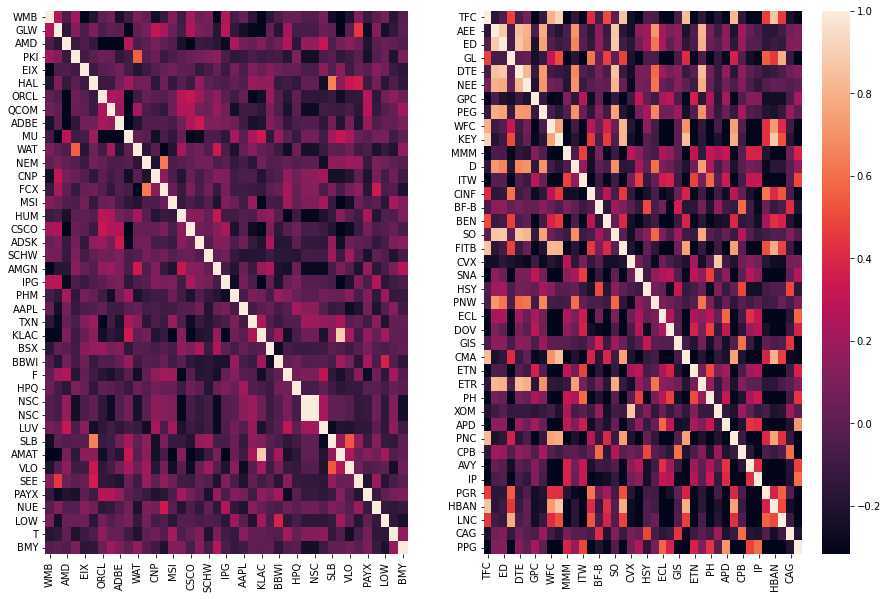

In [47]:
import seaborn as sns
import matplotlib.pylab as plt

# a heatmap with estimated correlation 
error_corr_train_max_df = pd.DataFrame(max40_companies).corr()
error_corr_train_min_df = pd.DataFrame(min40_companies).corr()

vmin = min(error_corr_train_max_df.values.min(), error_corr_train_min_df.values.min())
vmax = max(error_corr_train_max_df.values.max(), error_corr_train_min_df.values.max())

fig, axs = plt.subplots(1, 2, figsize = (15, 10), gridspec_kw=dict(width_ratios=[5,5.5]))
sns.heatmap(data = pd.DataFrame(error_corr_train_max_df).corr(), ax = axs[0], vmin = vmin, vmax = vmax, cbar = False)
sns.heatmap(data = pd.DataFrame(error_corr_train_min_df).corr(), ax = axs[1], vmin = vmin, vmax = vmax, cbar = True)

In [48]:
avg_corr_train_max = df_train.corr().abs().values[np.tril_indices(error_corr_train_max_df.shape[0], k = -1)].mean()
avg_corr_train_min = df_test.corr().abs().values[np.tril_indices(error_corr_train_min_df.shape[0], k = -1)].mean()
avg_res_corr_train_max = error_corr_train_max_df.abs().values[np.tril_indices(error_corr_train_max_df.shape[0], k = -1)].mean()
avg_res_corr_train_min = error_corr_train_min_df.abs().values[np.tril_indices(error_corr_train_min_df.shape[0], k = -1)].mean()
print(f'Average correlation training data for max 40 companies: {avg_corr_train_max:.2f}')
print(f'Average correlation training data for min 40 companies: {avg_corr_train_min:.2f}')
print(f'Average correlation left unexplained max data: {avg_res_corr_train_max:.2f}')
print(f'Average correlation left unexplained min data: {avg_res_corr_train_min:.2f}')

Average correlation training data for max 40 companies: 0.28
Average correlation training data for min 40 companies: 0.32
Average correlation left unexplained max data: 0.06
Average correlation left unexplained min data: 0.10


## Comments


The average correlation of the examined objects for train and test data **after applying** the autoencoder on the top and lowest 40 companies when it comes to recreation loss shows only 6% correalation for the top 40 companies but 10% correlation for the lowest 40 companies.

This indicates, that escpecilally the companies with the lowest error-rate are less suitable for our three hidden neurons.